**Why LSTM (Long Short-Term Memory)?**

Long Short-Term Memory (LSTM) networks are commonly employed in time series forecasting projects due to their ability to capture and model complex temporal dependencies in sequential data. Unlike traditional feedforward neural networks or other time series models, LSTMs excel at handling sequences with long-term dependencies, making them particularly suitable for time series data where patterns and trends may vary over time. LSTMs have internal memory cells that can retain information for extended periods, allowing them to learn and remember patterns over different time scales. This is crucial for capturing seasonality, trends, and irregular patterns in time series data. Additionally, LSTMs can automatically adapt to varying time lags and handle multivariate time series, making them versatile for a wide range of forecasting tasks.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib as mpl
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
# Filter out specific ValueWarnings from statsmodels
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
!pip install tensorflow

### Importing data

In [6]:
client = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\client.csv")
hist_weather = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\historical_weather.csv")
data = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\train.csv")
forecast_weather = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\forecast_weather.csv")
electricity = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\electricity_prices.csv")
gas = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\gas_prices.csv")
# it would be used instead of df_station_to_county.county_name
locations=pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\county_lon_lats.csv")

### Preprocessing

### This code performs several data preprocessing tasks in a time series forecasting context:

- **Handling Missing Values:**
  - Removes rows with missing values in the 'target' column.
  
- **Datetime Handling:**
  - Converts the 'datetime' column to datetime format.
  - Renames and converts the 'forecast_date' column in the 'electricity' dataset to 'datetime' for later merging.
  - Adjusts the 'data_block_id' column in the 'client' dataset to align with the 'train' dataset.

- **Geospatial Data Processing:**
  - Rounds and merges geographical coordinates in 'forecast_weather' and 'hist_weather' datasets with county information.
  
- **Feature Engineering:**
  - Creates new temporal features such as 'year', 'month', 'day', 'hour', 'dayofweek', and 'dayofyear' in the 'train' dataset.
  
- **Target Variable Transformation:**
  - Rounds the 'latitude' and 'longitude' columns in 'forecast_weather' and 'hist_weather' datasets for consistency.
  
- **Weather Data Aggregation:**
  - Groups mean values of forecasted and historical weather features by hour and datetime.
  
- **Data Merging:**
  - Merges the 'train' dataset with various external datasets ('client', 'gas', 'electricity', 'forecast_weather', 'hist_weather') based on specific columns.
  
- **Handling Duplicate Values:**
  - Drops duplicate values in the historical weather datasets and removes the 'datetime' column.
  
- **Filling Missing Values:**
  - Fills missing values in the dataset using forward and backward filling, ensuring that hourly mean values are retained for each column.

- **Data Cleaning:**
  - Drops unnecessary columns ('level_0', 'level_1', 'row_id', 'data_block_id', 'year').

- **Data Return:**
  - Returns the processed 'data' dataframe.


In [7]:
# Code adapted from Kaggle notebook: [https://www.kaggle.com/code/renatoreggiani/enefit-best-lb-shared-with-early-stop/notebook]
def preTrain(data, client, hist_weather,
               forecast_weather, electricity, gas, locations):
    
    #Dropping (target) nan values
    data= data[data['target'].notnull()] 
    #Converting (datetime) column to datetime
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    #Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    #Converting (datetime) column to datetime
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)
    #Decreasing (data_block_id) in client data because it's 2 steps ahead from train's data (data_block_id)
    client['data_block_id'] -= 2
      
    """locations is a custom data that will help replace (latitude) and (longitude)
    columns by the counties for each coordination | you can find the data in Input """
    locations = locations.drop('Unnamed: 0', axis= 1) 
        
    #Rounding the (latitude) and (longitude) for 1 decimal fraction
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude',
                                                                    'longitude']].astype(float).round(1)
    #Merging counties in locations data with the coordinations in the forecast_weather data
    forecast_weather= forecast_weather.merge(locations, how='left',
                                             on=['longitude','latitude'])
    #dropping nan values
    forecast_weather.dropna(axis= 0, inplace= True)    
    #Converting (county) column to integer
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    #Dropping the columns we won't need | We will use the (forecast_datetime) column instead of the (origin_datetime)
    forecast_weather.drop(['origin_datetime', 'latitude',
                           'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    #Renaming (forecast_datetime) to (datetime) for merging with the train data later
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    #Converting (datetime) column to datetime
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    """Grouping all forecast_weather columns mean values by hour, So each hour
    will have the mean values of the forecast_weather columns""" 
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    """Grouping all forecast_weather columns mean values by hour and county, So each hour and county
    will have the mean values of the forecast_weather columns for each county""" 
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

    #Rounding the (latitude) and (longitude) for 1 decimal fraction           
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    #Merging counties in locations data with the coordinations in the historical_weather data
    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    #Dropping nan values
    hist_weather.dropna(axis= 0, inplace= True)
    #Dropping the columns we won't need
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)
    #Converting (county) to integer
    hist_weather['county'] = hist_weather['county'].astype('int64')
    #Converting (datetime) column to datetime
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    """Grouping all historical_weather columns mean values by hour, So each hour
    will have the mean values of the historical_weather columns"""     
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime',
                                                                                        'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime['datetime']= pd.to_datetime(
        hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step | (data_block_id will be used to merge with train data)
    hist_weather_datetime= hist_weather_datetime.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    """Grouping all historical_weather columns mean values by hour and county, So each hour
    will have the mean values of the historical_weather columns for each county"""   
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime_county['datetime']= pd.to_datetime(
        hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    #Merging (data_block_id) back after dropping it in the last step
    hist_weather_datetime_county= hist_weather_datetime_county.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    #Adding year column in train data
    data['year'] = data['datetime'].dt.year
    #Adding month column in train data
    data['month'] = data['datetime'].dt.month
    #Adding day column in train data
    data['day'] = data['datetime'].dt.day
    #Adding hour column in train data
    data['hour'] = data['datetime'].dt.hour
    #Adding dayofweek column in train data
    data['dayofweek'] = data['datetime'].dt.dayofweek
    #Adding dayofyear column in train data
    data['dayofyear']= data['datetime'].dt.dayofyear
    #Adding hour column to electricity used to merge with the train data
    electricity['hour'] = electricity['datetime'].dt.hour
    #Merging train data with client data
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    
    #Merging train data with gas data
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    #Merging train data with electricity data    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    
    #Merging train data with forecast_weather_datetime data    
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    #Merging train data with forecast_weather_datetime_county data    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    #Creating hour columns in both historical_weather data | used to merge both data with the train data
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    #Dropping duplicates and (datetime) column
    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    #Merging hist_weather_datetime with train data
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])


    #Merging hist_weather_datetime_county with train data
    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    #Filling nan values with hourly mean values for each column | Helps for the county missing value 
    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    #Dropping uneeded data
    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    return data

In [8]:
#Applying the Train function and storing our train data in the (train) variable
train= preTrain(data, client, hist_weather, forecast_weather, electricity, gas, locations)
train.head(10)

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,...,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county
0,0,0,1,0.713,0,2021-09-01 00:00:00+00:00,0,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
1,0,0,1,96.590,1,2021-09-01 00:00:00+00:00,0,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
2,0,0,2,0.000,0,2021-09-01 00:00:00+00:00,1,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
3,0,0,2,17.314,1,2021-09-01 00:00:00+00:00,1,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
4,0,0,3,2.904,0,2021-09-01 00:00:00+00:00,2,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
5,0,0,3,656.859,1,2021-09-01 00:00:00+00:00,2,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
6,0,1,0,0.000,0,2021-09-01 00:00:00+00:00,3,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
7,0,1,0,59.000,1,2021-09-01 00:00:00+00:00,3,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
8,0,1,1,0.000,0,2021-09-01 00:00:00+00:00,4,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0
9,0,1,1,501.760,1,2021-09-01 00:00:00+00:00,4,9,1,0,...,1028.7,84.6,90.0,6.1,0.0,4.113889,143.6,0.0,0.0,0.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 69 columns):
 #   Column                                                  Dtype              
---  ------                                                  -----              
 0   county                                                  int64              
 1   is_business                                             int64              
 2   product_type                                            int64              
 3   target                                                  float64            
 4   is_consumption                                          int64              
 5   datetime                                                datetime64[ns, UTC]
 6   prediction_unit_id                                      int64              
 7   month                                                   int32              
 8   day                                                     int32           

### Data transformation

This piece of code performs the following transformations on the 'train' DataFrame:

- Creates new features based on the sine and cosine of the 'hour' column, scaled to fit within the range [0, π/6] (for time-related periodicity).
- Creates new features based on the sine and cosine of the 'dayofyear' column, scaled to fit within the range [0, π/3] (for annual periodicity).
- Calculates the mean, standard deviation, and variance of the 'target' column.
  
These transformations are often applied to time-related features in time series data to extract periodic patterns and provide statistical measures for further analysis or model input. The sine and cosine transformations help capture cyclical patterns, and computing statistical measures of the target variable can be useful for normalization or as additional features in machine learning models.

In [10]:
# Code adapted from Kaggle notebook: [https://www.kaggle.com/code/renatoreggiani/enefit-best-lb-shared-with-early-stop/notebook]
# Data transformation and feature engineering

# Create Sine and Cosine Features for 'hour'
train['sin_hour'] = (np.pi * np.sin(train['hour']) / 12)  # Sine of 'hour' scaled to [0, π/6]
train['cos_hour'] = (np.pi * np.cos(train['hour']) / 12)  # Cosine of 'hour' scaled to [0, π/6]

# Create Sine and Cosine Features for 'dayofyear'
train['sin_dayofyear'] = (np.pi * np.sin(train['dayofyear']) / 183)  # Sine of 'dayofyear' scaled to [0, π/3]
train['cos_dayofyear'] = (np.pi * np.cos(train['dayofyear']) / 183)  # Cosine of 'dayofyear' scaled to [0, π/3]

# Calculate Statistical Features for 'target'
train['target_mean'] = train['target'].mean()  # Mean of 'target'
train['target_std'] = train['target'].std()    # Standard deviation of 'target'
train['target_var'] = train['target'].var()    # Variance of 'target'


In [11]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,...,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,sin_hour,cos_hour,sin_dayofyear,cos_dayofyear,target_mean,target_std,target_var
0,0,0,1,0.713,0,2021-09-01 00:00:00+00:00,0,9,1,0,...,0.0,0.0,0.0,0.0,0.261799,-0.014842,0.008628,274.85556,909.502378,827194.575618
1,0,0,1,96.590,1,2021-09-01 00:00:00+00:00,0,9,1,0,...,0.0,0.0,0.0,0.0,0.261799,-0.014842,0.008628,274.85556,909.502378,827194.575618
2,0,0,2,0.000,0,2021-09-01 00:00:00+00:00,1,9,1,0,...,0.0,0.0,0.0,0.0,0.261799,-0.014842,0.008628,274.85556,909.502378,827194.575618
3,0,0,2,17.314,1,2021-09-01 00:00:00+00:00,1,9,1,0,...,0.0,0.0,0.0,0.0,0.261799,-0.014842,0.008628,274.85556,909.502378,827194.575618
4,0,0,3,2.904,0,2021-09-01 00:00:00+00:00,2,9,1,0,...,0.0,0.0,0.0,0.0,0.261799,-0.014842,0.008628,274.85556,909.502378,827194.575618


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 76 columns):
 #   Column                                                  Dtype              
---  ------                                                  -----              
 0   county                                                  int64              
 1   is_business                                             int64              
 2   product_type                                            int64              
 3   target                                                  float64            
 4   is_consumption                                          int64              
 5   datetime                                                datetime64[ns, UTC]
 6   prediction_unit_id                                      int64              
 7   month                                                   int32              
 8   day                                                     int32           

The code creates a new DataFrame (`train_df`) by selecting specific columns from the original dataset (`train`). It reorders the columns, ensuring 'datetime' and 'target' are first and last, respectively. The selected columns include information like 'eic_count', 'installed_capacity', 'dayofyear', 'prediction_unit_id', and various target-related features. Finally, it prints information about the data types and memory usage of each column in the new DataFrame.

In [13]:
# Select relevant columns from the original DataFrame 'train'
selected_columns = ['datetime'] + [col for col in train.columns if col != 'datetime' and col != 'target'] + ['target']
train_df = train[selected_columns]

# Reorder columns in a new DataFrame 'train_df' for better organization
train_df = train_df[['datetime', 'eic_count', 'installed_capacity', 'dayofyear', 'prediction_unit_id',
                     'target_std', 'direct_solar_radiation_fcast_mean', 'surface_pressure_hist_mean_by_county',
                     'target']]

# Display information about data types and memory usage of 'train_df'
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 9 columns):
 #   Column                                Dtype              
---  ------                                -----              
 0   datetime                              datetime64[ns, UTC]
 1   eic_count                             float64            
 2   installed_capacity                    float64            
 3   dayofyear                             int32              
 4   prediction_unit_id                    int64              
 5   target_std                            float64            
 6   direct_solar_radiation_fcast_mean     float64            
 7   surface_pressure_hist_mean_by_county  float64            
 8   target                                float64            
dtypes: datetime64[ns, UTC](1), float64(6), int32(1), int64(1)
memory usage: 130.9 MB


In [14]:
# Extract columns from 'train_df' excluding 'datetime' and 'target'
cols = list(train_df)[1:9]

# Create a new DataFrame 'df_for_training' containing only the selected columns
df_for_training = train_df[cols].astype(float)


In [15]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data to learn the parameters (mean and standard deviation)
scaler = scaler.fit(df_for_training)

# Transform the original training data using the learned parameters to standardize the features
df_for_training_scaled = scaler.transform(df_for_training)

# Comment: StandardScaler is used to standardize (mean=0, std=1) the features of the training data.
# The fit method calculates the mean and standard deviation, and transform applies the transformation.
# This ensures that all features are on a similar scale, which is often important for certain machine learning algorithms.


This piece of code is part of a data preparation process for time series forecasting using a sliding window approach. Here's a breakdown of what it does:

- `trainX` and `trainY` are lists that will be used to store input sequences (features) and corresponding output sequences (target) for training the LSTM model.
- `n_future` and `n_past` are variables defining the number of future steps to predict and the number of past steps to consider for prediction, respectively.
- The loop iterates through the data from `n_past` to `len(df_for_training_scaled) - n_future + 1`.
- For each iteration, it extracts a sequence of `n_past` historical data points as the input feature (`trainX`), and the next data point (`n_future` steps ahead) as the target (`trainY`).
- The input sequence is a 2D array containing slices of the scaled training data, considering all columns (`0:df_for_training.shape[1]`).
- The target sequence (`trainY`) is a 1D array containing the scaled value of the data point `n_future` steps ahead.
- Essentially, it creates pairs of input-output sequences for training the LSTM model with a sliding window approach.

In [16]:
# Initialize empty lists to store input features and target values
trainX = []
trainY = []

# Define the number of future and past time steps
n_future = 1
n_past = 14

# Iterate through the data to create input sequences and corresponding target values
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    # Extract the input sequence for the current time step
    input_sequence = df_for_training_scaled[i - n_past: i, 0:df_for_training.shape[1]]
    
    # Extract the target value for the future time step
    target_value = df_for_training_scaled[i + n_future - 1: i + n_future, 0]
    
    # Append the input sequence and target value to the lists
    trainX.append(input_sequence)
    trainY.append(target_value)


In [17]:
#trainX = []
#trainY = []
#n_future = 1
#n_past = 14
#for i in range(n_past,len(df_for_training_scaled)-n_future +1):
    #trainX.append(df_for_training_scaled[i-n_past : i,0:df_for_training.shape[1]])
    #trainY.append(df_for_training_scaled[i+n_future -1:i +n_future,0])

In [18]:
# Convert the lists of input sequences and target values to NumPy arrays for compatibility with machine learning models
trainX, trainY = np.array(trainX), np.array(trainY)

In [19]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (2017810, 14, 8).
trainY shape == (2017810, 1).


### Training Model


* Sequential model is a linear stack of layers, typically for feedforward neural networks.
* The first LSTM layer processes input sequences and returns sequences.
* The second LSTM layer processes the output of the previous layer and does not return sequences.
* Dropout layer helps prevent overfitting by randomly setting a fraction of input units to zero during training.
* Dense layer produces the output with units matching the dimensionality of the target variable.

In [20]:
# Create a sequential model
model = Sequential()

# Add an LSTM layer with 64 units, ReLU activation function, and input shape matching the input data
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))

# Add another LSTM layer with 32 units and ReLU activation function, not returning sequences (final layer)
model.add(LSTM(32, activation='relu', return_sequences=False))

# Add dropout regularization with a rate of 0.2 to prevent overfitting
model.add(Dropout(0.2))

# Add a dense (fully connected) layer with the number of units matching the target variable dimensionality
model.add(Dense(trainY.shape[1]))

**Compile the Model:**
   - The `compile` method is used to configure the learning process of the model.
   - `optimizer='adam'`: Adam is a popular optimization algorithm.
   - `loss='mse'`: Mean Squared Error (MSE) is chosen as the loss function, commonly used for regression problems.

In [21]:
# Compile the model with the Adam optimizer and mean squared error (MSE) as the loss function
model.compile(optimizer='adam', loss='mse')

# Display a summary of the model architecture, including the number of parameters and layer configurations
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18688     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31137 (121.63 KB)
Trainable params: 31137 (121.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- **Model Type:**
  - It's a simple sequence of layers, one after the other.

- **Layers:**
  - Two types of layers are used:
    - LSTM layers process sequences of data.
    - A Dense layer produces the final output.

- **Parameters:**
  - Parameters are the internal variables the model learns during training.
  - There are 31,137 parameters in total.

In short, it's a sequential model using LSTM and Dense layers to learn from data. The total parameters represent the internal settings learned by the model, making it capable of making predictions.

In [22]:
# Define early stopping callback to monitor validation loss, wait for patience epochs, and restore the best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model on the provided data with a batch size of 16, validation split of 10%, and early stopping callback
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=-1)

Epoch 1/10

113502/113502 [==============================] - 444s 4ms/step - loss: 0.0429 - val_loss: 0.0589
Epoch 2/10
113502/113502 [==============================] - 442s 4ms/step - loss: 0.0237 - val_loss: 0.0583
Epoch 3/10
113502/113502 [==============================] - 440s 4ms/step - loss: 0.2549 - val_loss: 2.1541
Epoch 4/10
113502/113502 [==============================] - 442s 4ms/step - loss: 0.4378 - val_loss: 5.7317
Epoch 5/10
113502/113502 [==============================] - 443s 4ms/step - loss: 0.2419 - val_loss: 0.1590


- **Early Stopping:** Implements early stopping during model training based on the validation loss. It monitors the validation loss, stops training if there is no improvement for a certain number of epochs (patience), and restores the best weights.

- **Model Training:** Trains the model using the provided training data (`trainX` and `trainY`) for a specified number of epochs (10 in this case) with a batch size of 16.

- **Validation Split:** Allocates a portion (10%) of the training data for validation during model training.

- **Callback:** Utilizes the `EarlyStopping` callback during training to enable the early stopping mechanism.

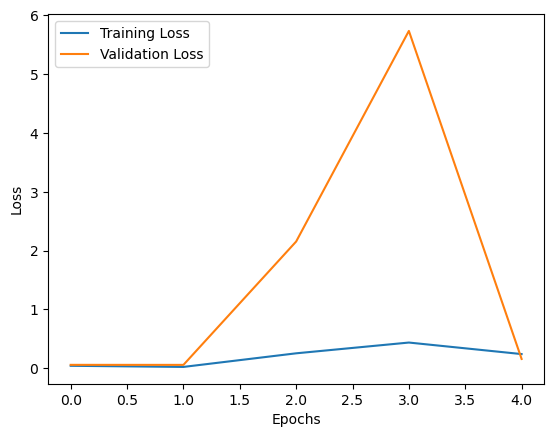

In [23]:
# 'history' is the result of model.fit
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In LSTM training, the plot between training loss and validation loss is typically used to assess the model's performance during training.

1. **Decreasing Losses:** Ideally, both training and validation losses should decrease over epochs. This indicates that the model is learning from the training data and generalizing well to unseen validation data. In this case, there is no expected trend happened.

2. **Training Loss Lower Than Validation Loss:** In a well-behaved model, the training loss is expected to be lower than the validation loss. If the training loss is significantly lower than the validation loss, it suggests the model might be overfitting, capturing noise in the training data that doesn't generalize well.

3. **Convergence:** Look for convergence of both training and validation losses. If both losses stabilize and remain constant over several epochs, it might indicate that further training may not significantly improve the model.


**In light of the model's limitation in learning from the training data, I undertook further steps for the sake of learning and experience, despite not achieving satisfactory results. This proactive approach was motivated by a commitment to continuous improvement and the pursuit of knowledge.**

This piece of code does the following:

- Sets the variable `n_future` to 90, representing the number of future time periods to forecast.
- Creates a date range for the forecast period starting from the last datetime value in the 'datetime' column of the `train` DataFrame.
- The `pd.date_range` function generates a sequence of dates with a frequency of 1 day (`'1d'`) for the next 90 days.
- Converts the resulting date range to a list named `forecast_period_dates`.


In [24]:
# Set the number of future time periods to forecast
n_future = 90

# Generate a date range for the forecast period starting from the last datetime value in the training data
# The resulting date range will cover the next 90 days with a frequency of 1 day
forecast_period_dates = pd.date_range(train['datetime'].iloc[-1], periods=n_future, freq='1d').tolist()

In [25]:
# Predict future values using the trained model
forecast = model.predict(trainX[-n_future:])

# Explanation:
# 1. The 'trainX' list contains input sequences used for training the model.
# 2. The '[-n_future:]' indexing is used to select the last 'n_future' input sequences from 'trainX'.
#    This is done to obtain the input sequences for which we want to make predictions.
# 3. The 'model.predict()' method is called to generate forecasts for the selected input sequences.
# 4. The predicted values are stored in the 'forecast' variable.

3/3 [==============================] - 0s 2ms/step


Breakdown of what the code does:

- `forecast` is repeated along the last axis (axis=-1) `df_for_training.shape[1]` times.
- This repetition is done using `np.repeat` to create copies of the `forecast` array.
- The result is stored in the variable `forecast_copies`.
- The inverse transformation is then applied to `forecast_copies` using `scaler.inverse_transform`.
- The resulting array is indexed to extract the first column (`[:, 0]`), representing the target variable.
- The values are stored in the variable `y_pred_future`.

In [26]:
# Repeat the 'forecast' array along the last axis 'df_for_training.shape[1]' times
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)

# Inverse transform the repeated forecast values using the scaler
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]


In [27]:
# Initialize an empty list to store date components
forecast_dates = []

# Iterate through each datetime object in forecast_period_dates
for time_i in forecast_period_dates:
    # Extract the date component from the datetime object and append to the list
    forecast_dates.append(time_i.date())

In [28]:
# Create a DataFrame to store forecasted results
df_forecast = pd.DataFrame({'Date': np.array(forecast_dates), 'target': y_pred_future})

# Convert the 'Date' column to datetime format for better handling
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [29]:
# Select relevant columns from the DataFrame
original = train_df[['datetime', 'target']]

# Convert the 'datetime' column to datetime data type
original['datetime'] = pd.to_datetime(original['datetime'])

# Filter the DataFrame to include only data from January 1, 2023, onwards
original = original[original['datetime'] >= '2023-01-01 00:00:00+00:00']

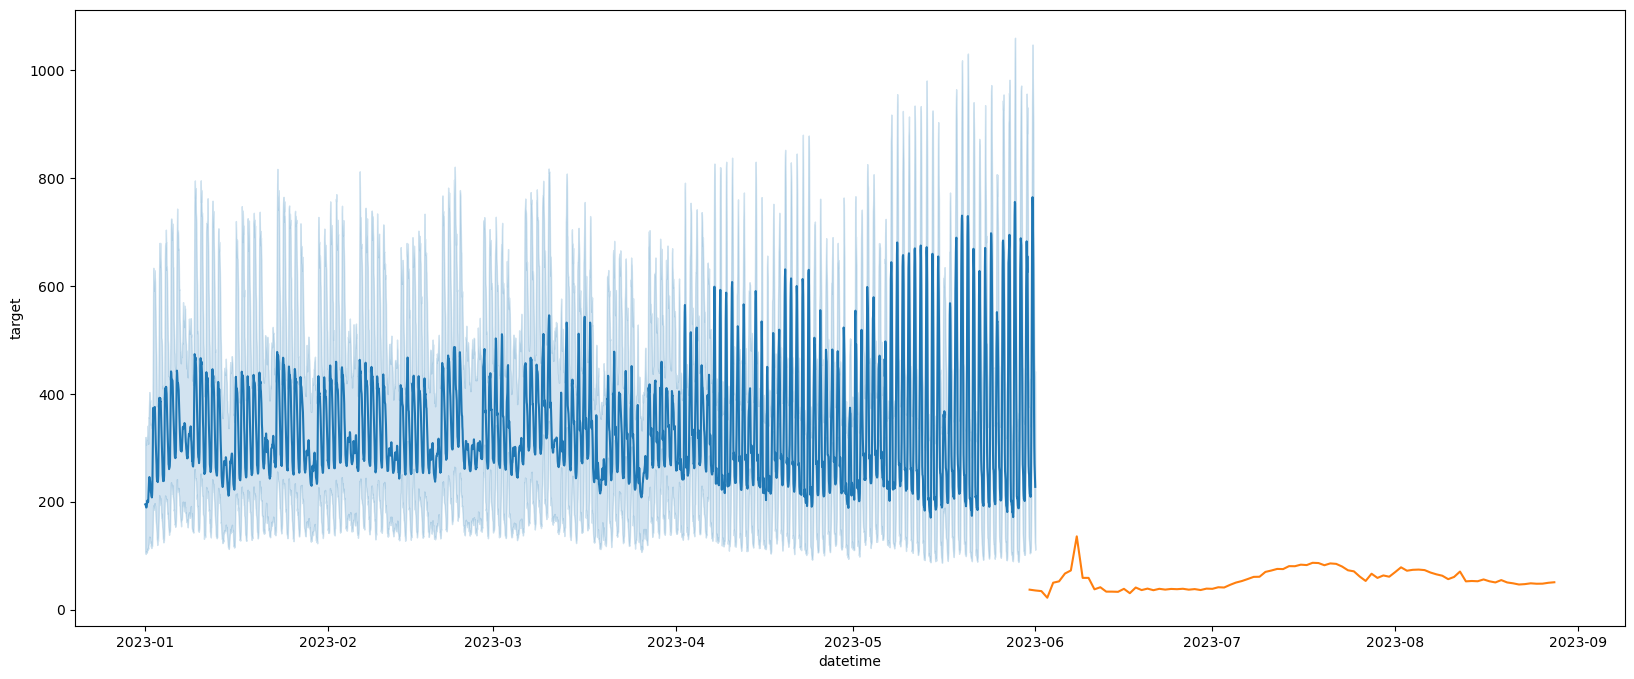

In [30]:
# Set the size of the figure for the upcoming plot
plt.figure(figsize=(20, 8))

# Plot the 'target' values over time for the 'original' dataset
sns.lineplot(data=original, x='datetime', y='target', label='Original Data')

# Plot the 'target' values over time for the 'df_forecast' dataset
sns.lineplot(data=df_forecast, x='Date', y='target', label='Forecast Data')

# Display the plot
plt.show()

Based on our findings, it is evident that achieving a precise prediction is challenging, as illustrated by the substantial gap observed between the actual and predicted values in the plotted data. This analysis indicates the need for optimization strategies to enhance the accuracy and reliability of our predictions.

### Next Steps

As we did not get satisfactory results from an LSTM model, there are several steps that we can take to improve or fix the performance. Here are some suggestions:

1. **Data Preprocessing:**
   - **Scaling:** Ensure that your input features are properly scaled. LSTMs are sensitive to the scale of input data.
   - **Normalization:** Normalize your target variable if it has a wide range of values.

2. **Feature Engineering:**
   - **Additional Features:** Consider adding more relevant features that might improve the model's ability to learn patterns.
   - **Time Features:** Extract and incorporate time-related features such as day of week, month, or season.

3. **Model Architecture:**
   - **Complexity:** Adjust the model complexity. You might try increasing the number of LSTM layers or units, but be cautious about overfitting.
   - **Dropout:** Add dropout layers to prevent overfitting.
   - **Bidirectional LSTM:** Experiment with bidirectional LSTMs, which process the input sequence in both forward and backward directions.

4. **Training Configuration:**
   - **Learning Rate:** Adjust the learning rate. Experiment with different learning rates to find the one that works best.
   - **Epochs:** Train for more epochs or use early stopping to prevent overfitting.

5. **Sequence Length:**
   - **Adjust Sequence Length:** Experiment with different sequence lengths. A longer sequence length might capture more complex patterns.

6. **Ensemble Models:**
   - **Ensemble Methods:** Consider using ensemble methods with multiple LSTM models to improve predictive performance.

7. **Hyperparameter Tuning:**
   - **Grid Search:** Perform a grid search or random search for optimal hyperparameters.

8. **Regularization Techniques:**
   - **L1/L2 Regularization:** Apply L1 or L2 regularization to the LSTM layers to prevent overfitting.

9. **Loss Function:**
   - **Custom Loss Function:** If your problem has specific characteristics, consider designing a custom loss function that aligns better with your objectives.

10. **Evaluate Residuals:**
    - **Residual Analysis:** Analyze residuals to understand where the model is making errors and whether there are specific patterns that need attention.